# Closed-form equivalent layer associated with magnetic field

This code illustrates how to compute a planar closed-form equivalent layer that reproduces the magnetic scalar potential and its derivatives at points above the layer.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import eqlayer, filters, transforms, convolve
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import constants as cts

### Model

In [2]:
# Create a model formed by a single prism
#model = np.array([[-500, 500, 0, 2000, 10, 1010]])
model = np.array([[-500, 500, 0, 2000, 150, 1010]])

# total magnetization intensity, inclination and declination
h, inc, dec = 2., -42., -23.
magnetization = np.array([[h, inc, dec]])

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)

yp = np.ravel(yp)
xp = np.ravel(xp)

# constant vertical coordinate of the simulated gravity data
z_data = -150

zp = np.zeros_like(yp) + z_data

coordinates = np.vstack([xp, yp, zp])

In [4]:
# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

In [5]:
print(dx, dy)

169.4915254237288 169.4915254237288


### Synthetic gravitational field

In [6]:
# magnetic scalar potential (in micro T x m)
V = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_potential')

# magnetic induction components (in nT)
bx = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

### Theoretical equivalent layer

Compute the theoretical physical-property distribution on the layer via Fourier transform.

In [7]:
# layer z
#z_layer = -150 + 2.5*(0.5*(dx+dy))
#z_layer = 2.5*(0.5*(dx+dy))
z_layer = 100.

In [8]:
# compute the pseudogravity anomaly
pseudo_grav = rp.grav(
    coordinates=coordinates, prisms=model, density=np.array([magnetization[0,0]]), field='g_z', scale=False
)

In [9]:
# compute 2D Fourier transform of pseudogravity anomaly with padding
FT_pseudo_grav = transforms.DFT(data=pseudo_grav.reshape(shape), pad_mode='linear_ramp')

# compute wavenumbers
kx, ky, kz = transforms.wavenumbers(FT_pseudo_grav.shape, dx, dy)

In [10]:
# define the continuation filter
down_continuation_filter = [filters.continuation(kz=kz, dz=z_layer-z_data)]

In [11]:
# compute the downward continued field in Fourier domain
FT_pseudo_grav_downward_layer = convolve.compute(FT_pseudo_grav, down_continuation_filter)

In [12]:
# transform the downward continued field to space domain
pseudo_grav_downward_layer = transforms.IDFT(FT_pseudo_grav_downward_layer, unpad=True, grid=False)

In [13]:
# theoretical equivalent layer
p_theoretical = ((dx*dy*cts.CM)/(2*np.pi))*pseudo_grav_downward_layer

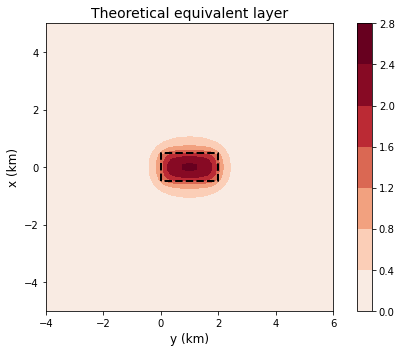

In [14]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(p_theoretical))

plt.title('Theoretical equivalent layer', fontsize=14)
plt.axis('scaled')
plt.contourf(
    yp.reshape(shape)*0.001, 
    xp.reshape(shape)*0.001, 
    p_theoretical.reshape(shape), 
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*area[0], 0.001*area[1])
plt.xlim(0.001*area[2], 0.001*area[3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Magnetic field predicted by the theoretical equivalent layer

In [15]:
# magnetic field components
field_scales = [cts.T2MT, cts.T2NT, cts.T2NT, cts.T2NT]
field_names = ['potential', 'x', 'y', 'z']
field_units = ['$\mu$ T $\\times$ m', 'nT', 'nT', 'nT']

In [16]:
# list for storing the predicted magnetic field components
predicted_fields = []

In [17]:
for name, scale in zip(field_names, field_scales):
    # kernel matrix associated with the equivalent layer
    G = eqlayer.kernel_matrix_dipoles(coordinates, z_layer, inc, dec, field=name)
    # compute the predicted field and update the list
    predicted_fields.append(scale*G@p_theoretical)

### Plot the results

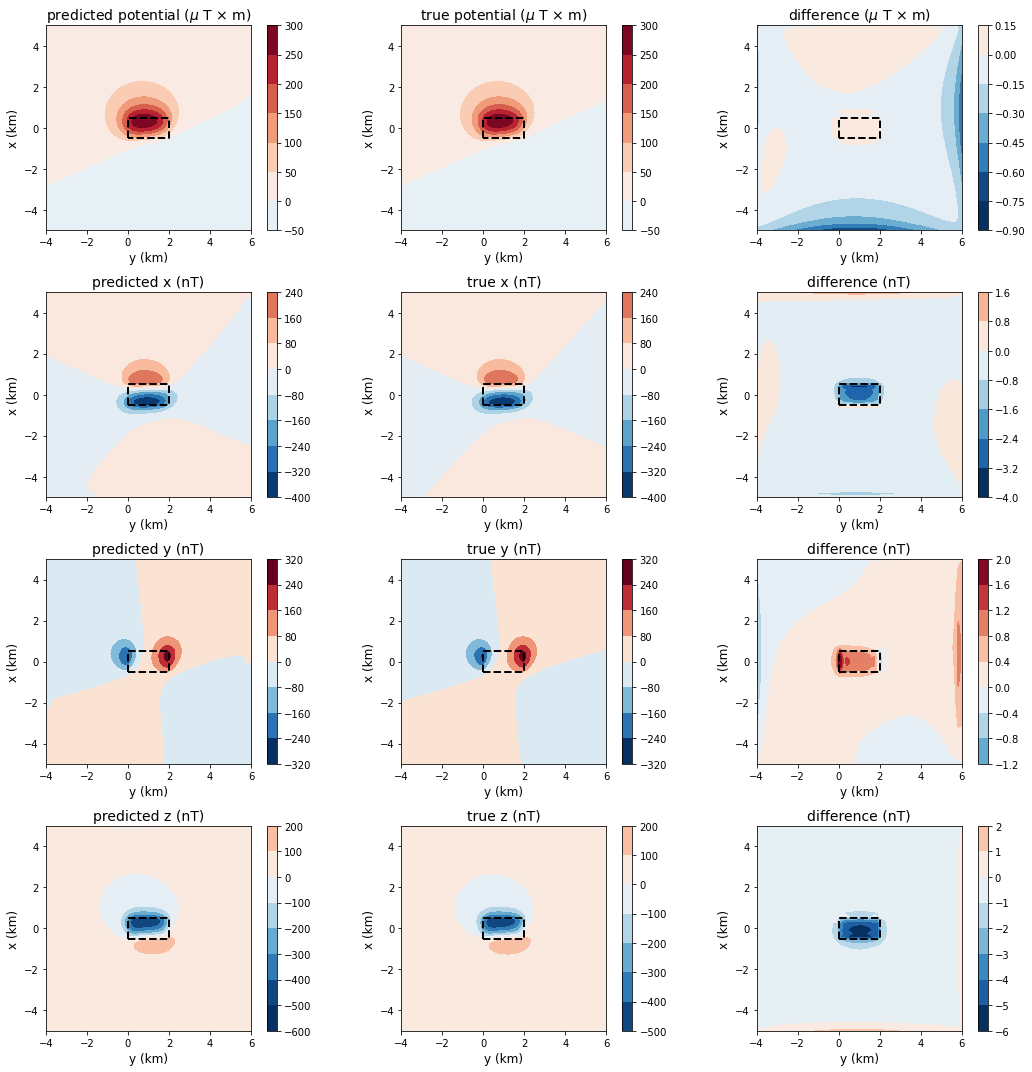

In [18]:
true_fields = [V, bx, by, bz]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('predicted {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,13)]

plt.figure(figsize=(15,15))

for w, window in enumerate(windows):

    plt.subplot(4,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()